## Show that social capital can be identified by co-location in Friends & Family

`!pip install pygeohash`

In [1]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: Sep 8, 2022
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm
from tueplots import bundles
plt.rcParams.update({**bundles.neurips2022(), 'figure.dpi': 150.0})

### Locations to geohash and set intersection

In [2]:
# Load in Location.csv.bz2
locations = pd.read_csv('Location.csv.bz2', compression='bz2')

FileNotFoundError: [Errno 2] No such file or directory: 'Location.csv.bz2'

In [ ]:
# Affine transformation back
mitx = 42.36103905631169
locations['x'] = mitx - (locations['x'] - locations['x'].median()) # Center on MIT
q1, q3 = locations['x'].quantile([0.25, 0.75])
locations['x'] = locations['x']/(q3 - q1) * (2/69) # Make 2 mile IQR

mity = -71.08726617035774
locations['y'] = mity - (locations['y'] - locations['y'].median()) # Center on MIT
q1, q3 = locations['y'].quantile([0.25, 0.75])
locations['y'] = locations['y']/(q3 - q1) * (2/69) # Make 2 mile IQR

locations['dte'] = pd.to_datetime(locations['date']).dt.date.apply(str)


In [ ]:
import pygeohash as pgh
locations['geohash'] = locations.apply(lambda x: pgh.encode(x['x'], x['y'], precision=8), axis=1)

In [ ]:
intersections = []
IDs_to_geohash_counter = locations.groupby('participantID')['geohash'].apply(lambda x: x.tolist()).to_dict()
IDs_to_geohash_counter = {k: Counter(v) for k, v in IDs_to_geohash_counter.items()}
for p1ID, p1 in IDs_to_geohash_counter.items():
    for p2ID, p2 in IDs_to_geohash_counter.items():
        intersection_size = sum([c for k,c in p1.items() if k in p2])
        intersections.append((p1ID, p2ID, intersection_size))
intersections_df = pd.DataFrame(intersections, columns=['p1', 'p2', 'intersection_size'])

In [ ]:
intersections_date = []
IDs_to_geohash_date_counter = locations.groupby('participantID')['geohash'].apply(lambda x: x.tolist()).to_dict()
IDs_to_geohash_date_counter = {k: Counter(v) for k, v in IDs_to_geohash_date_counter.items()}
for p1ID, p1 in IDs_to_geohash_date_counter.items():
    for p2ID, p2 in IDs_to_geohash_date_counter.items():
        intersection_size = sum([c for k,c in p1.items() if k in p2])
        intersections_date.append((p1ID, p2ID, intersection_size))
intersections_date_df = pd.DataFrame(intersections_date, columns=['p1', 'p2', 'intersection_date_size'])

<AxesSubplot: ylabel='Frequency'>

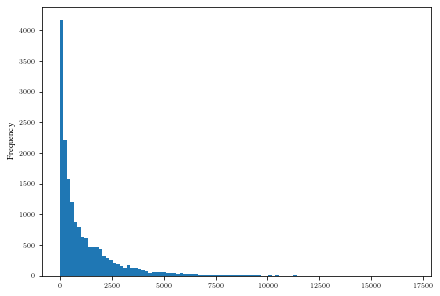

In [ ]:
intersections_df['intersection_size'].plot.hist(bins=100)

### Bluetooth Proximity

In [3]:
BluetoothProximity = pd.read_csv('BluetoothProximity.csv.bz2', compression='bz2')
BluetoothProximity = BluetoothProximity.dropna().groupby(['participantID', 'participantID.B'])['date'].count()
BluetoothProximity = BluetoothProximity.reset_index().rename({'participantID':'p1', 'participantID.B':'p2', 'date':'proximity'}, axis=1)
BluetoothProximity

FileNotFoundError: [Errno 2] No such file or directory: 'BluetoothProximity.csv.bz2'

### Survey Friendship

In [9]:
SurveyFriendship = pd.read_csv('SurveyFriendship.csv')
SurveyFriendship = SurveyFriendship.groupby(['source', 'target'])['weight'].mean()
SurveyFriendship = SurveyFriendship.reset_index().rename({'source': 'p1', 'target': 'p2', 'weight':'friendship'}, axis=1)
SurveyFriendship['nonzeroF'] = 1*(SurveyFriendship['friendship'] > 0)
SurveyFriendship

,p1,p2,friendship,nonzeroF
0,fa10-01-01,fa10-01-01,3.333333,1
1,fa10-01-01,fa10-01-02,3.333333,1
2,fa10-01-01,fa10-01-03,1.000000,1
3,fa10-01-01,fa10-01-04,1.000000,1
4,fa10-01-01,fa10-01-05,1.000000,1
...,...,...,...,...
15357,sp10-01-56,sp10-01-52,0.000000,0
15358,sp10-01-56,sp10-01-53,1.000000,1
15359,sp10-01-56,sp10-01-54,3.000000,1
15360,sp10-01-56,sp10-01-55,3.000000,1


### SMS and Calls

In [10]:
SMSLog = pd.read_csv('SMSLog.csv.bz2')
SMSLog = SMSLog.dropna().groupby(['participantID.A', 'participantID.B'])['local_time'].count()
SMSLog = SMSLog.reset_index().rename({'participantID.A': 'p1', 'participantID.B': 'p2', 'local_time':'sms'}, axis=1)

In [11]:
CallLog = pd.read_csv('CallLog.csv.bz2')
CallLog = CallLog.dropna().groupby(['participantID.A', 'participantID.B'])['local_time'].count()
CallLog = CallLog.reset_index().rename({'participantID.A': 'p1', 'participantID.B': 'p2', 'local_time':'call'}, axis=1)

In [12]:
Communications = SMSLog.set_index(['p1', 'p2']).join(CallLog.set_index(['p1', 'p2'])).reset_index().fillna(0)
Communications['communications'] = Communications['sms'] + Communications['call']
Communications = Communications.drop(['sms', 'call'], axis=1)
Communications = Communications.dropna()
Communications

,p1,p2,communications
0,fa10-01-01,fa10-01-01,159.0
1,fa10-01-01,fa10-01-02,1832.0
2,fa10-01-01,fa10-01-05,3.0
3,fa10-01-01,fa10-01-07,1.0
4,fa10-01-02,fa10-01-01,1860.0
...,...,...,...
247,sp10-01-53,fa10-01-81,127.0
248,sp10-01-53,fa10-01-82,2.0
249,sp10-01-53,sp10-01-01,52.0
250,sp10-01-53,sp10-01-52,747.0


## Correlation of Social Capital and Location

In [13]:
all_df = intersections_df.join(SurveyFriendship.set_index(['p1', 'p2']), how='left', on=['p1', 'p2']).join(BluetoothProximity.set_index(['p1', 'p2']), how='left', on=['p1', 'p2']).join(Communications.set_index(['p1', 'p2']), how='left', on=['p1', 'p2']).join(intersections_date_df.set_index(['p1', 'p2']), how='left', on=['p1', 'p2'])

In [14]:
all_df.corr('pearson')

,intersection_size,friendship,nonzeroF,proximity,communications,intersection_date_size
intersection_size,1.000000,0.261175,0.143883,0.347991,0.274089,1.000000
friendship,0.261175,1.000000,0.734892,0.308246,0.285896,0.261175
nonzeroF,0.143883,0.734892,1.000000,0.139923,0.058915,0.143883
proximity,0.347991,0.308246,0.139923,1.000000,0.434732,0.347991
communications,0.274089,0.285896,0.058915,0.434732,1.000000,0.274089
intersection_date_size,1.000000,0.261175,0.143883,0.347991,0.274089,1.000000


# Repeat for $r$

In [15]:
corr_values = {}
corr_values_already_friends = {}
for r in tqdm(range(3,10)):
    locations['geohash'] = locations.apply(lambda x: pgh.encode(x['x'], x['y'], precision=r), axis=1)
    locations['geodte'] = locations['geohash'] + locations['dte']

    intersections = []
    IDs_to_geohash_counter = locations.groupby('participantID')['geohash'].apply(lambda x: x.tolist()).to_dict()
    IDs_to_geohash_counter = {k: Counter(v) for k, v in IDs_to_geohash_counter.items()}
    for p1ID, p1 in IDs_to_geohash_counter.items():
        for p2ID, p2 in IDs_to_geohash_counter.items():
            intersection_size = sum([c for k,c in p1.items() if k in p2])
            intersections.append((p1ID, p2ID, intersection_size))
    intersections_df = pd.DataFrame(intersections, columns=['p1', 'p2', 'intersection_size'])

    intersections_date = []
    IDs_to_geohash_date_counter = locations.groupby('participantID')['geohash'].apply(lambda x: x.tolist()).to_dict()
    IDs_to_geohash_date_counter = {k: Counter(v) for k, v in IDs_to_geohash_date_counter.items()}
    for p1ID, p1 in IDs_to_geohash_date_counter.items():
        for p2ID, p2 in IDs_to_geohash_date_counter.items():
            intersection_size = sum([c for k,c in p1.items() if k in p2])
            intersections_date.append((p1ID, p2ID, intersection_size))
    intersections_date_df = pd.DataFrame(intersections_date, columns=['p1', 'p2', 'intersection_date_size'])

    all_df = intersections_df.join(SurveyFriendship.set_index(['p1', 'p2']), how='left', on=['p1', 'p2']).join(
        BluetoothProximity.set_index(['p1', 'p2']), how='left', on=['p1', 'p2']).join(
            Communications.set_index(['p1', 'p2']), how='left', on=['p1', 'p2']).join(
                intersections_date_df.set_index(['p1', 'p2']), how='left', on=['p1', 'p2'])
    all_df['log_intersection'] = np.log10(all_df['intersection_size'] + 1)
    all_df['boolean_friendship'] = (all_df['friendship'] > 0)*1
    corr_values[r] = all_df.corr('pearson')

    already_friends = all_df[(~all_df['friendship'].isna()) & (all_df['friendship'] > 0)]
    corr_values_already_friends[r] = already_friends.corr('pearson')

    if r==8:
        best_all_df = all_df.copy()

100%|██████████| 7/7 [01:33<00:00, 13.34s/it]


/Users/tobin/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


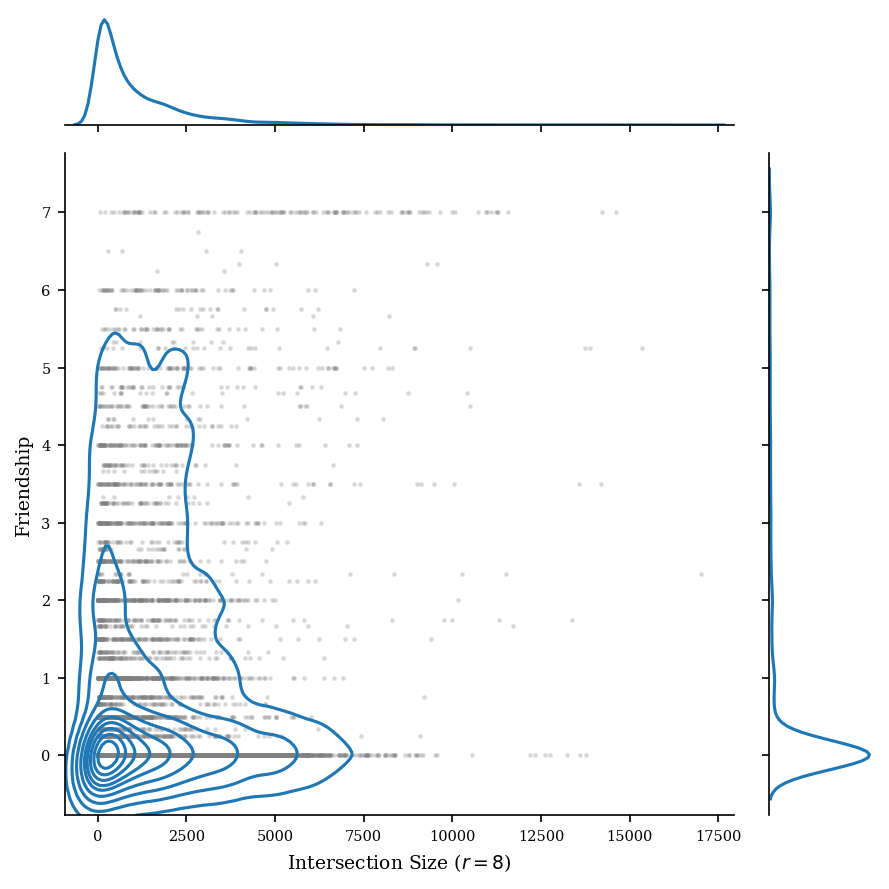

In [32]:
with mpl.rc_context(rc={'text.usetex': False}):
    pt = sns.jointplot(x = best_all_df['intersection_size'],y=best_all_df['friendship'], kind='kde')
    pt.ax_joint.scatter(best_all_df['intersection_size'], best_all_df['friendship'], alpha=0.2, s=2, zorder=0, c='grey')
    pt.ax_joint.set_xlabel('Intersection Size ($r=8$)')
    pt.ax_joint.set_ylabel('Friendship')
    plt.tight_layout()
    plt.savefig('figs/friendship_intersection_scatter.png', dpi=400)

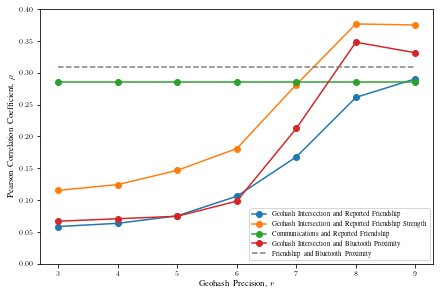

In [16]:
fig, ax = plt.subplots(1,1)
x = range(3,10)
ax.plot(x, [v.loc['intersection_size', 'friendship'] for r,v in corr_values.items()], 'o-', 
label='Geohash Intersection and Reported Friendship')
ax.plot(x, [v.loc['intersection_size', 'friendship'] for r,v in corr_values_already_friends.items()], 'o-', 
label='Geohash Intersection and Reported Friendship Strength')
# ax.plot(x, [v.loc['log_intersection', 'friendship'] for r,v in corr_values.items()], 'o-', 
# label='Log Geohash Intersection and Reported Friendship')
# ax.plot(x, [v.loc['intersection_size', 'communications'] for r,v in corr_values.items()], 'o-', 
# label='Geohash Intersection and Communications')
ax.plot(x, [v.loc['communications', 'friendship'] for r,v in corr_values.items()], 'o-', 
label='Communications and Reported Friendship')
ax.plot(x, [v.loc['intersection_size', 'proximity'] for r,v in corr_values.items()], 'o-', 
label='Geohash Intersection and Bluetooth Proximity')
ax.plot(x, [v.loc['friendship', 'proximity'] for r,v in corr_values.items()],  '--', 
label='Friendship and Bluetooth Proximity', c='grey')

ax.set_ylim(0, 0.4)
ax.legend(loc='lower right')
ax.set_xlabel('Geohash Precision, $r$')
ax.set_ylabel('Pearson Correlation Coefficient, $\\rho$')

plt.tight_layout()
plt.savefig('figs/geohash_precision_correlations.pdf', dpi=400)

In [ ]:
[v.loc['intersection_size', 'friendship'] for r,v in corr_values_already_friends.items()]

In [16]:
corr_values_already_friends[8]

,intersection_size,friendship,nonzeroF,proximity,communications,log_intersection,boolean_friendship
intersection_size,1.000000,0.376662,NaN,0.445220,0.302582,0.749260,NaN
friendship,0.376662,1.000000,NaN,0.395861,0.303971,0.281588,NaN
nonzeroF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proximity,0.445220,0.395861,NaN,1.000000,0.432482,0.307023,NaN
communications,0.302582,0.303971,NaN,0.432482,1.000000,0.281327,NaN
log_intersection,0.749260,0.281588,NaN,0.307023,0.281327,1.000000,NaN
boolean_friendship,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Regress friendship on intersection size and bluetooth proximity
from statsmodels.formula.api import ols
model = ols("friendship ~ intersection_size + proximity", data=best_all_df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             friendship   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     638.0
Date:                Fri, 16 Sep 2022   Prob (F-statistic):          1.82e-262
Time:                        11:44:47   Log-Likelihood:                -17955.
No. Observations:               10676   AIC:                         3.592e+04
Df Residuals:                   10673   BIC:                         3.594e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3586      0.01

# Plots

In [46]:
import libgeohash as gh


# Prettymaps
from prettymaps import *
# Vsketch
import vsketch
# OSMNX
import osmnx as ox
# Matplotlib-related
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from descartes import PolygonPatch
import matplotlib.patches as patches
import geopandas as gpd


# Shapely
from shapely.geometry import *
from shapely.affinity import *
from shapely.ops import unary_union

# Style parameters
palette = ['#433633']  #'#FF5E5B'
background_c = '#ffffff' #'#F2F4CB'
dilate = 100
center = (42.361358642578125, -71.09184265136719)
radius = 600

In [90]:
# We're gonna manually draw the geohash grid by picking which geohashes
def get_geohash_grid(geo, depth=1, lw=1, showtext=True):
    neighbours_on_edge, neighbours_inside = list(gh.neighbors(geo).values()), [geo]
    for i in range(depth):
        temp_neighbours = []
        for neighbour in neighbours_on_edge:
            temp_neighbours.extend(list(gh.neighbors(neighbour).values()))
        neighbours_inside.extend(neighbours_on_edge)
        neighbours_on_edge = set([geo for geo in temp_neighbours if geo not in neighbours_inside])
    return neighbours_inside
    
all_geohashes_to_draw_big = get_geohash_grid(gh.encode(center[0], center[1], precision=6), depth=1)
all_geohashes_to_draw_medium = get_geohash_grid(gh.encode(center[0], center[1], precision=7), depth=20)
all_geohashes_to_draw_small = get_geohash_grid(gh.encode(center[0], center[1], precision=8), depth=50)

In [91]:
central_geo_6 = gh.encode(center[0], center[1], precision=6)
neighbors = gh.neighbors(central_geo_6)
all_geohashes_to_draw_small = [geo for geo in all_geohashes_to_draw_small if geo[:-2] in [neighbors['s'], neighbors['se'], neighbors['sw']]]
all_geohashes_to_draw_medium = [geo for geo in all_geohashes_to_draw_medium if geo[:-1] in [central_geo_6, neighbors['e'], neighbors['w'], 
                                                                                          neighbors['s'], neighbors['se'], neighbors['sw']]]

In [92]:
plt.rcParams.update({'text.usetex': True, 'figure.dpi': 400.0})

In [123]:
def plot_performance_graph(ax):
    x = range(3,10)
    ax.plot(x, [v.loc['intersection_size', 'friendship'] for r,v in corr_values.items()], 'o-', 
    label='Geohash Intersection and Reported Friendship', c="#FF5E5B")
    ax.plot(x, [v.loc['intersection_size', 'friendship'] for r,v in corr_values_already_friends.items()], 's-', 
    label='Geohash Intersection and Reported Friendship (Existing Friends)', c = '#FF5E5B')
    # ax.plot(x, [v.loc['log_intersection', 'friendship'] for r,v in corr_values.items()], 'o-', 
    # label='Log Geohash Intersection and Reported Friendship')
    ax.plot(x, [v.loc['intersection_size', 'communications'] for r,v in corr_values.items()], 'o-', 
    label='Geohash Intersection and Communications', c='#FCE19C')
    ax.plot(x, [v.loc['intersection_size', 'proximity'] for r,v in corr_values.items()], 'o-', 
    label='Geohash Intersection and Bluetooth Proximity', c='#8BB174')
    ax.plot(x, [v.loc['friendship', 'proximity'] for r,v in corr_values.items()],  '--', 
    label='Bluetooth Proximity and Reported Friendship', c='#433633')

    ax.set_ylim(0, 0.4)
    ax.legend(bbox_to_anchor=(0.5,-0.6), loc='lower center', fontsize=7)
    ax.set_xlabel('Geohash Precision, $r$')
    ax.set_ylabel('Pearson Correlation Coefficient, $\\rho$')

In [130]:
def make_map_plot(ax):
    # Plot
    layers = plot(
        center, radius = radius,
        ax = ax,
        layers = {
            'perimeter': {'circle': False, 'dilate': dilate},
            'streets': {
                'width': {
                    'primary': 5,
                    'secondary': 4,
                    'tertiary': 3,
                    'residential': 2,
                    'footway': 1,
                },
                'circle': False,
                'dilate': dilate
            },
            'building': {
                'tags': {'building': True},
                'union': False,
                'circle': False,
                'dilate': dilate
            },
            'green': {
                'tags': {
                    'landuse': ['grass', 'village_green'],
                    'leisure': 'park'
                },
                'circle': False,
                'dilate': dilate
            },
        },
    drawing_kwargs = {
                'perimeter': {'fill': False, 'lw': 0, 'zorder': 0},
                'background': {'fc': background_c, 'zorder': -1},
                'green': {'fc': '#8BB174', 'ec': '#2F3737', 'lw': 1, 'zorder': 1}, # 'hatch_c': '#A7C497', 'hatch': 'ooo...', 
                'forest': {'fc': '#64B96A', 'ec': '#2F3737', 'lw': 1, 'zorder': 2},
                'water': {'fc': '#a8e1e6', 'ec': '#2F3737', 'hatch_c': '#9bc3d4', 'hatch': 'ooo...', 'lw': 1, 'zorder': 3},
                'beach': {'fc': '#FCE19C', 'ec': '#2F3737', 'hatch_c': '#d4d196', 'hatch': 'ooo...', 'lw': 1, 'zorder': 3},
                'parking': {'fc': background_c, 'ec': '#2F3737', 'lw': 1, 'zorder': 3},
                'streets': {'fc': '#2F3737', 'ec': '#475657', 'alpha': 1, 'lw': 0, 'zorder': 4},
                'building': {'palette': palette, 'ec': '#2F3737', 'lw': .5, 'zorder': 5},
                
            },
        osm_credit = {'x': 0.5, 'y': 0.5, 'color': '#FFFFFF', 'zorder':-100, 'fontsize':0.5}
    )

    # # Draw left text
    # ax.text(
    #     xmin-.06*dx, ymin+.5*dy,
    #     'Barcelona, Spain',
    #     color = '#2F3737',
    #     rotation = 90,
    #     fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 35),
    # )
    # # Draw top text
    # ax.text(
    #     xmax-.35*dx, ymax+.02*dy,
    #     "41° 23′ N, 2° 11′ E",
    #     color = '#2F3737',
    #     fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 20),
    # )


    # Set bounds
    xmin, ymin, xmax, ymax = layers['perimeter'].bounds
    dx, dy = xmax-xmin, ymax-ymin
    # dx, dy = 0,0
    ax.set_xlim(xmin-.01*dx, xmax+.01*dx)
    ax.set_ylim(ymin-.01*dy, ymax+.01*dy)


    def convert_to_shitting_meters(lon, lat):
        return ((xmax - radius) - ((center[1] - lon)*111139), (ymax - radius) - (center[0]-lat)*111139)
    ctsm = convert_to_shitting_meters # Rename for convenience


    def draw_geo_border(geo, showtext=True, lw=1, color='#FF5E5B'):
        border = gh.bbox(geo)
        e, n = ctsm(border['e'], border['n'])
        w, s = ctsm(border['w'], border['s'])

        # Draw square around geohash
        ax.add_patch(patches.Rectangle(
            (w, s), e-w, n-s, facecolor = 'none', edgecolor = color,  lw = lw, zorder = 100))
        # Add geohash text to center
        if showtext:
            if (xmax > (w+e)/2 > xmin) and (ymax > (s+n)/2 > ymin):
                ax.text((w+e)/2, (s+n)/2, geo,color = color, ha = 'center', va = 'center', zorder = 100, fontdict={'size': 10})

    for geo in all_geohashes_to_draw_big:
        draw_geo_border(geo, showtext=False, lw=3, color='#FF5E5B')

    for geo in all_geohashes_to_draw_medium:
        draw_geo_border(geo, showtext=False, lw=1, color='#FF5E5B')

    for geo in all_geohashes_to_draw_small:
        draw_geo_border(geo, showtext=False, lw=0.5, color='#FF5E5B')


    # Add labels outside the axis to the right
    ax.text(0.99,0.2, '$r=8$', color = '#2F3737', transform=ax.transAxes, size=10, zorder=102)
    ax.text(0.99,0.5, '$r=7$', color = '#2F3737', transform=ax.transAxes, size=10, zorder=102)
    ax.text(0.99,0.8, '$r=6$', color = '#2F3737', transform=ax.transAxes, size=10, zorder=102)


    # Make a polygon thr covers the whole canvas
    ymin_ax, ymax_ax = ax.get_ylim()
    xmin_ax, xmax_ax = ax.get_xlim()
    axes_polygon = Polygon([(xmin_ax-dx, ymin_ax-dy), (xmax_ax+dx, ymin_ax-dy), (xmax_ax+dx, ymax_ax+dy), (xmin_ax-dx, ymax_ax+dy)])
    perimeter_polygon = layers['perimeter']
    difference_polygon = axes_polygon.symmetric_difference(perimeter_polygon) 

    # Draw white difference_polygon on canvas 
    gpd.GeoSeries(difference_polygon).plot(color='#FFFFFF', ax=ax, zorder=101)

/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:317: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(lines)
/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:317: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(lines)
/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:222: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  multipolys = reduce(lambda x,y: x+y, [list(x) for x in multipolys]) if len(multipolys) > 0 else []
/Users/tobin/miniforge3/lib/p

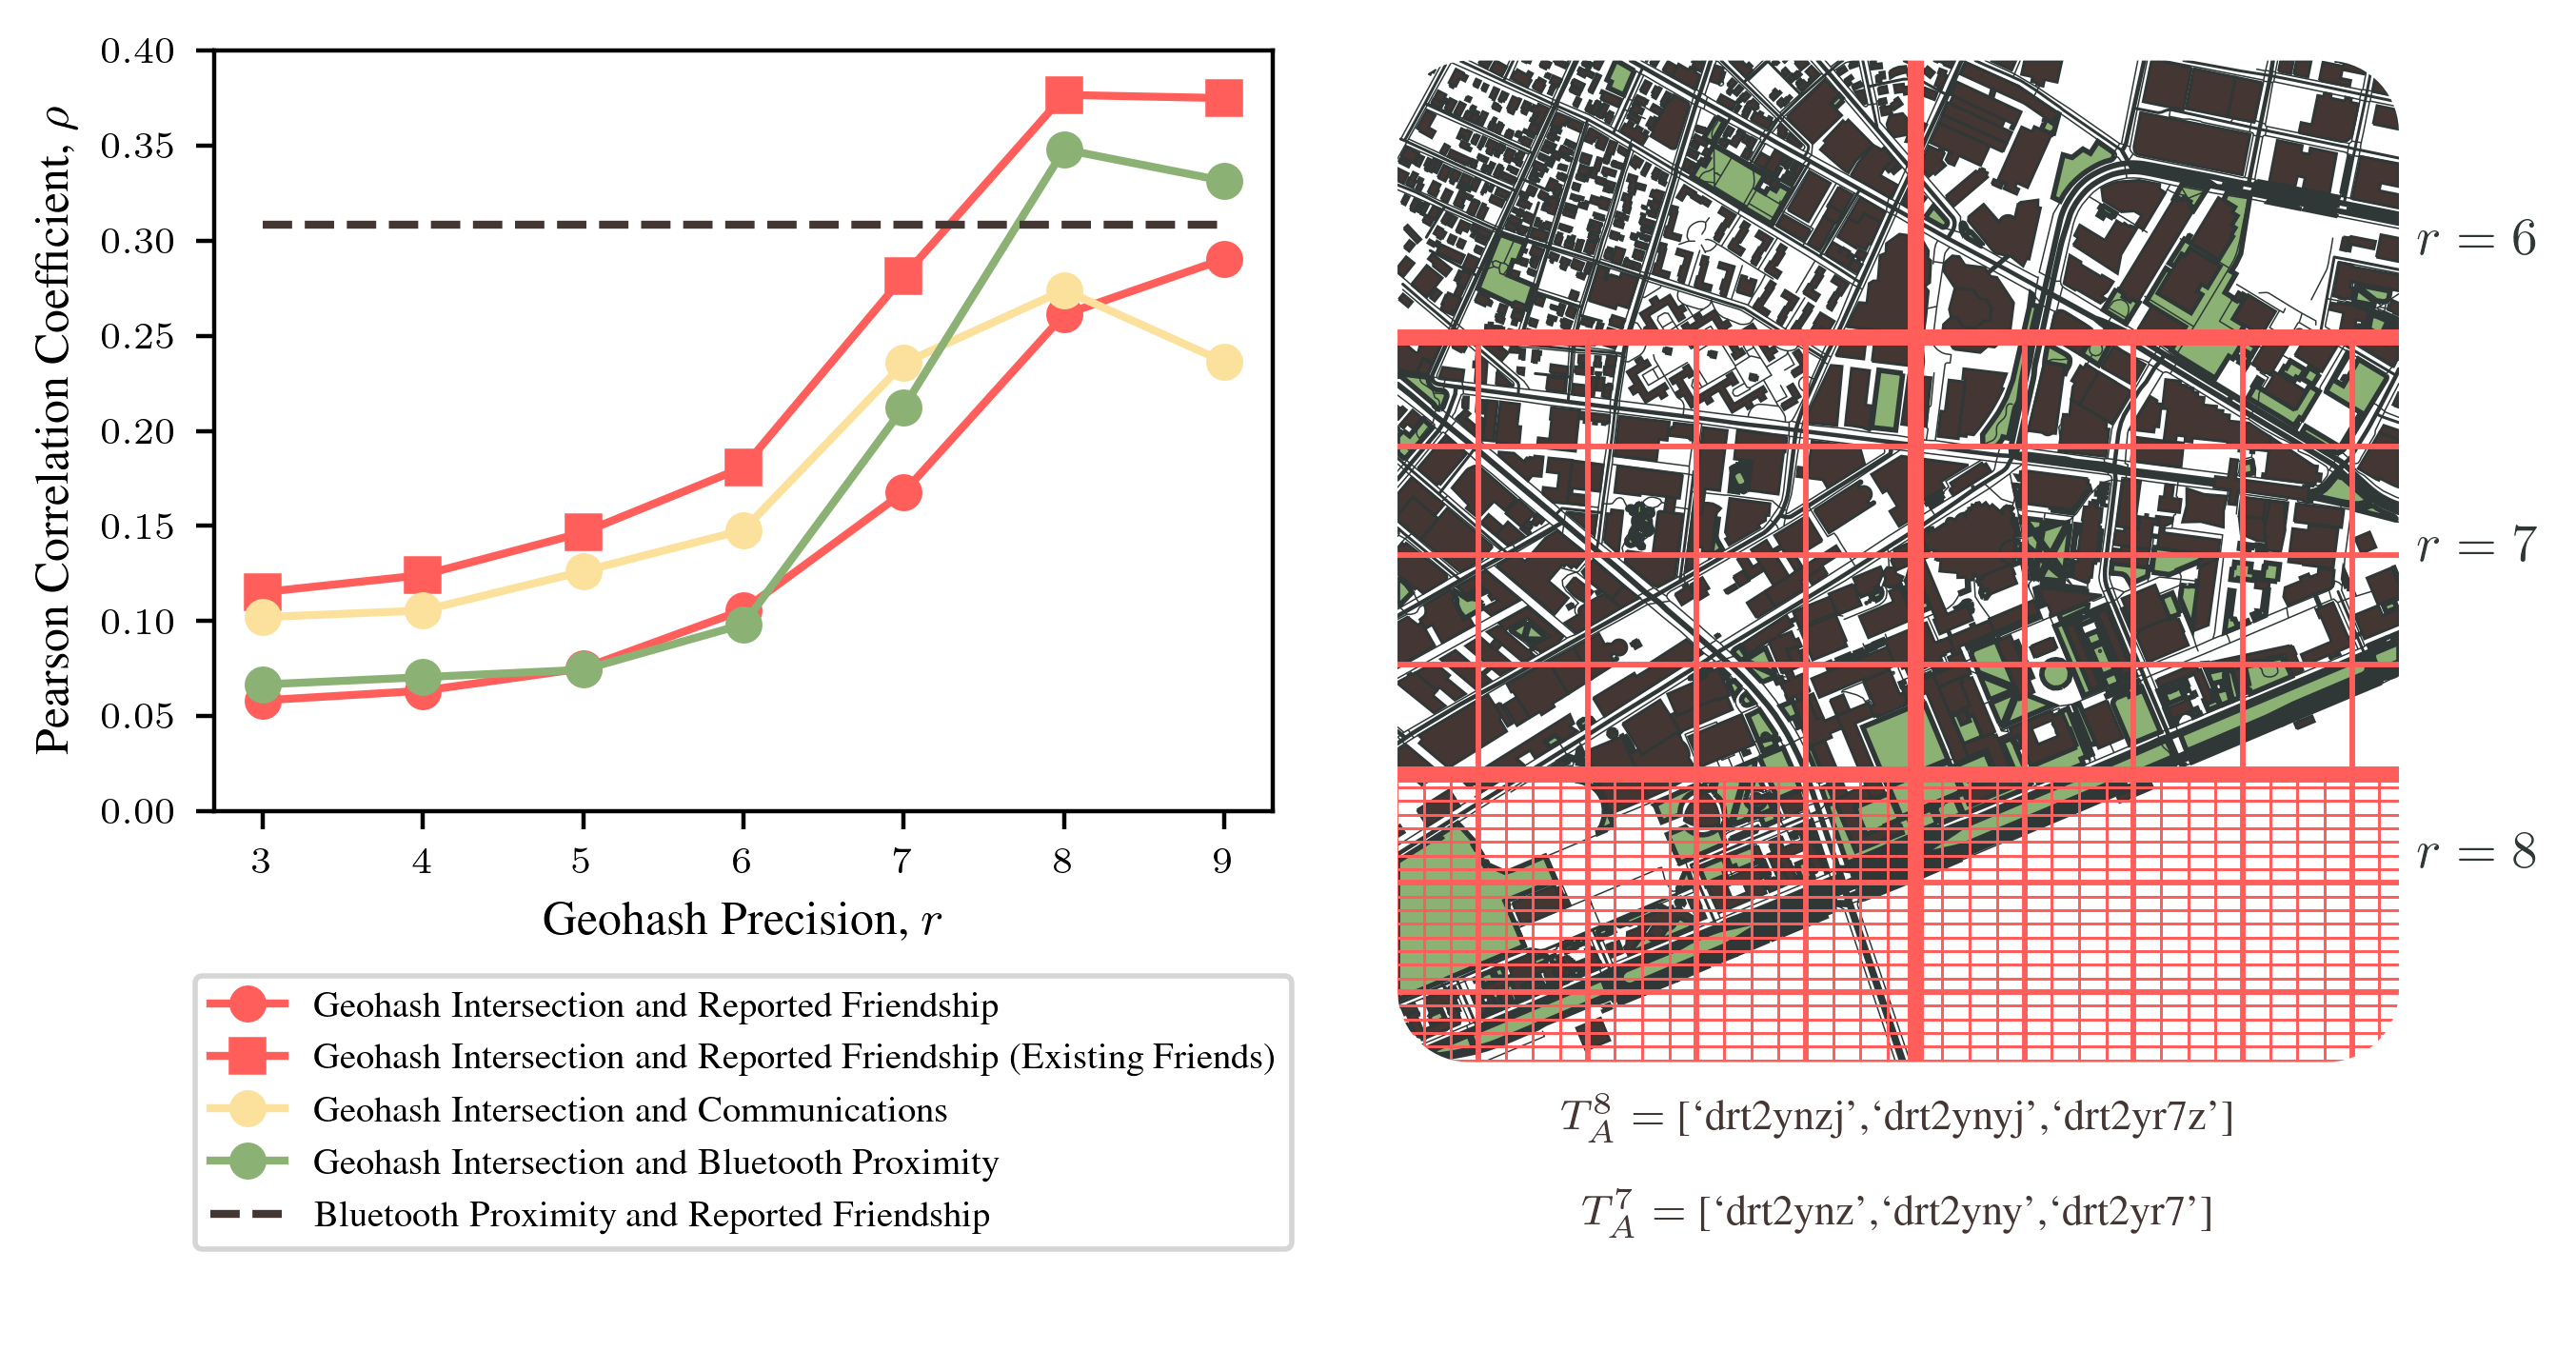

In [133]:
# Figure to combine plots
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(7.5,4.46))
gs = gridspec.GridSpec(10, 4)

ax_perform = fig.add_subplot(gs[0:6, 0:2])
plot_performance_graph(ax_perform)

ax_map = fig.add_subplot(gs[0:8, 2:4])
make_map_plot(ax_map)

ax_geohashes = fig.add_subplot(gs[8:, 2:4])
geoashs_with_arrows = ['drt2ynzj','drt2ynyj', 'drt2yr7z'] 
# ax_geohashes.text(0.5, 0.5, 'Geohashes', color = '#2F3737', transform=ax_geohashes.transAxes, size=10, zorder=102, ha='center', va='center')
ax_geohashes.text(0.5, 0.9, "$T_A^8 =$ [`" +"',`".join(geoashs_with_arrows)+"']", color = '#433633', transform=ax_geohashes.transAxes, size=8, zorder=102, ha='center', va='center')
ax_geohashes.text(0.5, 0.5, "$T_A^7 =$ [`" +"',`".join([g[:-1] for g in geoashs_with_arrows])+"']", color = '#433633', transform=ax_geohashes.transAxes, size=8, zorder=102, ha='center', va='center')

# FF5E5B

ax_geohashes.axis('off')

# arrow = patches.ConnectionPatch(
#     xyA,
#     xyB,
#     coordsA=ax1.transData,
#     coordsB=ax2.transData,
#     # Default shrink parameter is 0 so can be omitted
#     color="black",
#     arrowstyle="-|>",  # "normal" arrow
#     mutation_scale=30,  # controls arrow head size
#     linewidth=3,
# )
# fig.patches.append(arrow)

plt.tight_layout()
# plt.savefig('geohash_metaplot.pdf', bbox_inches='tight')
plt.savefig('geohash_metaplot.png', dpi=500, bbox_inches='tight')